# Testing pipeline

In this notebook, we construct a pipeline using modular functions to:
<ol>
    <li>Parse data documents</li>
    <li>Split them into chunks</li>
    <li>Embed the text in the chunks</li>
    <li>Push our embeddings to Pinecone (and save them locally as JSONs too)</li>
</ol>

We also generate some stats and visualizations about the chunks:
<ul>
    <li>The max length of a chunk</li>
    <li>The average number of tokens per chunk</li>
    <li>The distribution of lengths of chunks</li>
</ul>

### Imports

In [1]:
from pypdf import PdfReader
import json
import nltk
from boilerpy3 import extractors

from sentence_transformers import SentenceTransformer
from openai import OpenAI
from dotenv import load_dotenv
import os
from sklearn.metrics.pairwise import cosine_similarity
import random
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import time

import uuid

import re

from pinecone import Pinecone, ServerlessSpec

import tiktoken

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/fayad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Environment variables

In [2]:
load_dotenv()

True

In [3]:
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [4]:
PINECONE_API_KEY = os.environ["PINECONE_API_KEY"]

In [5]:
PINECONE_INDEX_NAME = os.environ["PINECONE_INDEX_NAME"]

### Parsing

As mentioned in the vector-database notebook, we inspected why some pushes were failing and found that one of the reasons was that certain PDF chunks were huge because they included some hash function output within \<latexit> tags from latex conversion. We included a regular expression matching technirue to eliminate those portions.

The rest are direct copies of the functions in the other notebook.

In [6]:
def read_text_with_metadata_from_pdfs(file_path):
    reader = PdfReader(file_path)
    num_pages = len(reader.pages)
    data = []
    
    # Define a regex pattern to detect <latexit> tags
    latexit_pattern = r"<latexit[^>]*>.*?</latexit>"
    
    for i in range(num_pages):
        text = reader.pages[i].extract_text()
        cleaned_text = re.sub(latexit_pattern, "", text)
        data.append({
            "file_type": "pdf",
            "file_name": file_path,
            "marker": i, # To identify where in the document this chunk is from
            "text": cleaned_text
        })

    return data

In [7]:
def read_text_with_metadata_from_htmls(file_path):
    # Use ArticleExtractor from boilerpy3
    extractor = extractors.ArticleExtractor()
    data = []
    try:
        clean_content = extractor.get_content_from_file(file_path)
        clean_content = nltk.sent_tokenize(clean_content)
        seq_num = 0
        for content in clean_content:
            data.append({
                "file_type": "html",
                "file_name": file_path,
                "text": content,
                "marker": seq_num
            })
            seq_num += 1
        
    except Exception as e:
        print(f"Error with BoilerPy3 extraction: {e}")
    finally:
        return data

In [8]:
def read_code_md_outputs_with_metadata_from_notebooks(file_path):
    # Load the notebook file
    with open(file_path, 'r', encoding='utf-8') as f:
        notebook = json.load(f)

    content = []
    seq_num = 0
    
    # Extract cells
    for cell in notebook.get('cells', []):
        cell_type = cell.get('cell_type')
        if cell_type == 'markdown': # Markdown cell
            md_content = "Text block:\n"
            md_content += "".join(cell.get('source', [])) + "\n"
            # print(md_content)
            content.append({
                "file_type": "ipynb",
                "file_name": file_path,
                "marker": seq_num,
                "text": md_content
            })
        elif cell_type == 'code':
            code_content = "Code block:\n"
            code_content += "".join(cell.get('source', [])) + "\n"
            # print(code_content)
            # code_source = ''.join(code_content)
            # outputs = []
            code_content += "Output:\n"
            
            # Extract outputs
            for output in cell.get('outputs', []):
                if output.get('output_type') == 'stream':
                    code_content += "".join(output.get('text', [])) + "\n"
                    # print(output_content)
                    # outputs.append(output_content)
                elif output.get('output_type') == 'execute_result':
                    code_content += "".join(output.get('data', {}).get('text/plain', [])) + "\n"
                    # print(output_content)
                    # outputs.append(output_content)
                elif output.get('output_type') == 'error':
                    code_content += "Error: ".join(output.get('traceback', [])) + "\n"
                    # print(output_content)
                    # outputs.append('Error: ' + output_content)

            content.append({
                "file_type": "ipynb",
                "file_name": file_path,
                "marker": seq_num,
                "text": code_content
            })

        seq_num += 1
    
    return content

In [9]:
def read_text_with_metadata_from_qa_csvs(qa_doc_path):
    qas = pd.read_csv(qa_doc_path, skiprows=1, names=["info", "question", "answer"])
    qas["info"] = qas["info"].fillna("No extra information given")
    data = []
    for index, row in qas.iterrows():
        text = f"Info: {row['info']}\nQuestion: {row['question']}\nAnswer: {row['answer']}"
        data.append({
            "file_type": "csv",
            "file_name": "test",
            "marker": index+1,
            "sub_marker": index+1, # Not necessary since we are not chunking
            "text": text,
            "first_10_words": " ".join(text.split()[:10])
        })

    return data

### Chunking

As mentioned in the vector-database notebook, sometimes the chunk had too much text because the tokens were not appropriately counted or maybe sometimes large numbers were parsed and tokenized weirdly. Using OpenAI's tiktoken generates better chunks and we make that adaptation here in the sequential_chunk_text_tiktoken() function.

In [10]:
tokenizer = tiktoken.get_encoding("cl100k_base")

In [11]:
def sequential_chunk_text(data, max_tokens=512, overlap=50):
     
    chunked_data = []
    
    for entry in data:
        text = entry['text'].split("\n")  # Split text into sentences/lines
        chunks = []
        chunk = []
        current_tokens = 0
        sub_marker = 0
        
        for idx, sentence in enumerate(text):
            sentence_tokens = len(sentence.split())  # Approximation of token count
            if current_tokens + sentence_tokens > max_tokens:
                # Finalize current chunk
                chunk_text = " ".join(chunk)
                chunks.append({
                    **entry,  # Copy the original dictionary fields
                    'text': chunk_text,
                    'sub_marker': sub_marker,
                    'first_10_words': " ".join(chunk_text.split()[:10])
                })
                sub_marker += 1
                
                # Start a new chunk with overlap
                overlap_sentences = chunk[-overlap:] if overlap < len(chunk) else chunk
                chunk = overlap_sentences[:]
                current_tokens = sum(len(s.split()) for s in overlap_sentences)
            
            # Add the current sentence to the chunk
            chunk.append(sentence)
            current_tokens += sentence_tokens
        
        # Add the last chunk
        if chunk:
            chunk_text = " ".join(chunk)
            chunks.append({
                **entry,
                'text': chunk_text,
                'sub_marker': sub_marker,
                'first_10_words': " ".join(chunk_text.split()[:10])
            })
        
        # Append all chunks for this entry to the result
        chunked_data.extend(chunks)
    
    return chunked_data

In [12]:
def sequential_chunk_text_tiktoken(data, max_tokens=512, overlap=50, tokenizer=tokenizer):
     
    chunked_data = []
    
    for entry in data:
        text = entry['text']
        tokens = tokenizer.encode(text, disallowed_special=())  # Tokenize the entire text, ignore special tokens
        chunks = []
        current_tokens = []
        sub_marker = 0
        
        i = 0
        while i < len(tokens):
            # Add tokens to the current chunk
            current_tokens.append(tokens[i])
            
            # If max_tokens is exceeded, finalize the chunk
            if len(current_tokens) >= max_tokens:
                chunk_text = tokenizer.decode(current_tokens[:max_tokens])  # Decode back to text
                chunks.append({
                    **entry,  # Copy original metadata
                    'text': chunk_text,
                    'sub_marker': sub_marker,
                    'first_10_tokens': " ".join(chunk_text.split()[:10])
                })
                sub_marker += 1
                
                # Handle overlap for the next chunk
                overlap_tokens = current_tokens[-overlap:] if overlap < len(current_tokens) else current_tokens
                current_tokens = overlap_tokens[:]
            
            i += 1
        
        # Add the last chunk if not empty
        if current_tokens:
            chunk_text = tokenizer.decode(current_tokens)
            chunks.append({
                **entry,
                'text': chunk_text,
                'sub_marker': sub_marker,
                'first_10_tokens': " ".join(chunk_text.split()[:10])
            })
        
        # Append all chunks for this entry to the result
        chunked_data.extend(chunks)
    
    return chunked_data

In [13]:
def generate_chunks_df(directory, qas = False):
    start_time = time.time()
    overall_df = pd.DataFrame()
    for file in os.listdir(directory):
        file_path = directory+file
        print(f"Working on: {file_path}")
        if qas:
            temp_data = read_text_with_metadata_from_qa_csvs(file_path)
        else:
            extension = file_path.split(".")[-1]
            if extension == "pdf":
                temp_data = read_text_with_metadata_from_pdfs(file_path)
            elif extension == "html":
                temp_data = read_text_with_metadata_from_htmls(file_path)
            elif extension == "ipynb":
                temp_data = read_code_md_outputs_with_metadata_from_notebooks(file_path)
        # temp_chunks = sequential_chunk_text(temp_data)
        temp_chunks = sequential_chunk_text_tiktoken(temp_data)
        temp_chunks_df = pd.DataFrame(temp_chunks)
        overall_df = pd.concat([overall_df, temp_chunks_df], ignore_index=True)

    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Time taken to generate chunks: {execution_time:.6f} seconds")
    return overall_df

### Embedding

In [14]:
client = OpenAI(
    api_key = OPENAI_API_KEY
)

In [15]:
def get_embedding(text):
    response = client.embeddings.create(
        model="text-embedding-ada-002",
        input=text
    )
    data = response.data[0] # Single chunk
    return data.embedding

In [16]:
def generate_embeddings_df_json_and_save(df, save_file_name):
    save_dir = f"../data/output/embedding-jsons"
    if not os.path.exists(save_dir):
        print(f"Save directory {save_dir} does not exist. Creating it.")
        os.makedirs(save_dir)

    start_time = time.time()
    df["embedding"] = df["text"].apply(get_embedding)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Time taken to generate embeddings: {execution_time:.6f} seconds")
    df.to_json(f"{save_dir}/{save_file_name}", orient="records", lines=False)

    return df

### Vector database

We upsert the data in batches now instead of doing it all at once, this eliminates all errors.

In [17]:
pc = Pinecone(api_key=PINECONE_API_KEY)

In [18]:
# Test run
index_name = PINECONE_INDEX_NAME

if not pc.has_index(index_name):
    pc.create_index(
        name=index_name,
        dimension=1536,
        metric="cosine",
        spec=ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        )
    )

index = pc.Index(index_name)

In [19]:
def prepare_data_for_pinecone(df):
    pinecone_data = []
    for _, row in df.iterrows():
        embedding = list(row['embedding'])  # Ensure embedding is in list format
        # Prepare the metadata dictionary with the relevant columns
        metadata = {
            "file_type": row['file_type'],
            "file_name": row['file_name'],
            "marker": str(row['marker']),
            "sub_marker": str(row['sub_marker']),
            "first_10_tokens": row['first_10_tokens'],
            "text": row['text']
        }
        pinecone_data.append({
            'id': str(uuid.uuid4()),
            'values': embedding,
            'metadata': metadata
        })
    return pinecone_data

In [20]:
def batch_upsert_data_into_index(pc_data, index, batch_size=10):
    start_time = time.time()
    for i in range(0, len(pc_data), batch_size):
        batch = pc_data[i:i + batch_size]
        index.upsert(vectors=batch)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Time taken to upsert data: {execution_time:.6f}")

### Statistics

To generate some statistics about chunks and to display them

In [21]:
def generate_statistics(df):
    strings = df["text"].dropna()
    
    # Calculate string lengths
    string_lengths = strings.str.len()

    # Compute statistics
    stats = {
        "total_number": len(strings),
        "average_length": string_lengths.mean(),
        "shortest_string": strings[string_lengths.idxmin()] if not strings.empty else None,
        "longest_string": strings[string_lengths.idxmax()] if not strings.empty else None,
        "average_word_count": strings.str.split().apply(len).mean(),
        "length_distribution": string_lengths.value_counts().sort_index().to_dict(),
        "has_special_chars_count": strings.str.contains(r'[^\w\s]', na=False).sum(),
    }

    return stats

In [22]:
def display_statistics(stats, bucket_size):
    print(f"Total number of non-empty strings: {stats['total_number']}")
    print(f"Average length of the strings: {stats['average_length']}")
    print(f"Shortest string:\n{stats['shortest_string']}\n")
    print(f"Longest string:\n{stats['longest_string']}\n")
    print(f"Average word count of the strings: {stats['average_word_count']}")
    print(f"Number of strings with special characters: {stats['has_special_chars_count']}")

    length_df = pd.DataFrame(list(stats['length_distribution'].items()), columns=["Length", "Count"])
    length_df = length_df.sort_values("Length")  # Ensure it's sorted by length

    # Create bins using pandas.cut and sum the counts within each bin
    length_df['Bucket'] = pd.cut(length_df['Length'], bins=np.arange(0, length_df["Length"].max() + bucket_size, bucket_size), right=False)
    binned_df = length_df.groupby('Bucket', as_index=False)['Count'].sum()

    # Format the bins as strings for labeling the x-axis
    binned_df['Bucket'] = binned_df['Bucket'].apply(lambda x: f"{int(x.right)}")

    # Create the bar plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=binned_df, x="Bucket", y="Count", palette="viridis")

    # Customize the plot
    plt.title(f"Distribution of String Lengths (Binned to {bucket_size})", fontsize=16)
    plt.xlabel("Length Buckets", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

### Pipeline

#### Directories

In [23]:
# sample_dir = "../data/subset/"
sample_dir = f"../data/input/full/" # Run on entire dataset now
lectures = sample_dir + "lectures/"
references = sample_dir + "references/"
qas = sample_dir + "qas/"
notebooks = sample_dir + "notebooks/"
exercises = sample_dir + "exercises/"

#### Generate chunks and some stats

In [24]:
lectures_chunks_df = generate_chunks_df(lectures)

Ignoring wrong pointing object 38 0 (offset 0)
Ignoring wrong pointing object 65 0 (offset 0)


Working on: ../data/input/full/lectures/03-2019-1012_NMT_Lecture2.pdf


Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)
Ignoring wrong pointing object 18 0 (offset 0)
Ignoring wrong pointing object 23 0 (offset 0)
Ignoring wrong pointing object 25 0 (offset 0)
Ignoring wrong pointing object 27 0 (offset 0)
Ignoring wrong pointing object 32 0 (offset 0)
Ignoring wrong pointing object 34 0 (offset 0)
Ignoring wrong pointing object 36 0 (offset 0)
Ignoring wrong pointing object 41 0 (offset 0)
Ignoring wrong pointing object 43 0 (offset 0)
Ignoring wrong pointing object 45 0 (offset 0)
Ignoring wrong pointing object 50 0 (offset 0)
Ignoring wrong pointing object 52 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 59 0 (offset 0)
Ignoring wrong pointing object 61 0 (offset 0)
Ignoring wrong pointing object 63 0 (offset 0)
Ignoring wrong pointing object 68 0 (offset 0)
Ignoring wrong 

Working on: ../data/input/full/lectures/centauri-arcturan-align.pdf


Ignoring wrong pointing object 81 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 86 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 31 0 (offset 0)


Working on: ../data/input/full/lectures/knnlm.pdf
Working on: ../data/input/full/lectures/editdist.pdf
Working on: ../data/input/full/lectures/cross_attention.pdf
Working on: ../data/input/full/lectures/fewshot.pdf


Ignoring wrong pointing object 27 0 (offset 0)
parsing for Object Streams


Working on: ../data/input/full/lectures/05-phrase-based-models.pdf
Working on: ../data/input/full/lectures/vae.pdf
Working on: ../data/input/full/lectures/tokenization.pdf
Working on: ../data/input/full/lectures/centauri-arcturan.pdf


Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 11 0 (offset 0)
Ignoring wrong pointing object 117 0 (offset 0)
Ignoring wrong pointing object 118 0 (offset 0)


Working on: ../data/input/full/lectures/benchmarks.pdf
Working on: ../data/input/full/lectures/intro-learning-from-text.pdf
Working on: ../data/input/full/lectures/ff.pdf


Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 31 0 (offset 0)
Ignoring wrong pointing object 33 0 (offset 0)
Ignoring wrong pointing object 25 0 (offset 0)
Ignoring wrong pointing object 35 0 (offset 0)
Ignoring wrong pointing object 44 0 (offset 0)
Ignoring wrong pointing object 53 0 (offset 0)
Ignoring wrong pointing object 62 0 (offset 0)
Ignoring wrong pointing object 86 0 (offset 0)
Ignoring wrong pointing object 94 0 (offset 0)
Ignoring wrong pointing object 102 0 (offset 0)
Ignoring wrong pointing object 110 0 (offset 0)
Ignoring wrong pointing object 118 0 (offset 0)
Ignoring wrong pointing object 126 0 (offset 0)
Ignoring wrong pointing object 135 0 (offset 0)
Ignoring wrong pointing object 153 0 (offset 0)
Ignoring wrong pointing object 176 0 (offset 0)
Ignoring wrong pointing object 184 0 (offset 0)
Ignoring wrong pointing object 193 0 (offset 0)


Working on: ../data/input/full/lectures/mtintro.pdf
Working on: ../data/input/full/lectures/cipher-solve.pdf
Working on: ../data/input/full/lectures/parsing.pdf


Ignoring wrong pointing object 10 0 (offset 0)
Ignoring wrong pointing object 12 0 (offset 0)
Ignoring wrong pointing object 29 0 (offset 0)
Ignoring wrong pointing object 31 0 (offset 0)
Ignoring wrong pointing object 48 0 (offset 0)
Ignoring wrong pointing object 85 0 (offset 0)
Ignoring wrong pointing object 88 0 (offset 0)
Ignoring wrong pointing object 95 0 (offset 0)
Ignoring wrong pointing object 97 0 (offset 0)
Ignoring wrong pointing object 121 0 (offset 0)
Ignoring wrong pointing object 124 0 (offset 0)
Ignoring wrong pointing object 131 0 (offset 0)
Ignoring wrong pointing object 140 0 (offset 0)
Ignoring wrong pointing object 147 0 (offset 0)
Ignoring wrong pointing object 194 0 (offset 0)
Ignoring wrong pointing object 196 0 (offset 0)
Ignoring wrong pointing object 204 0 (offset 0)
Ignoring wrong pointing object 206 0 (offset 0)
Ignoring wrong pointing object 209 0 (offset 0)
Ignoring wrong pointing object 216 0 (offset 0)
Ignoring wrong pointing object 224 0 (offset 0)
I

Working on: ../data/input/full/lectures/fastattn.pdf
Working on: ../data/input/full/lectures/editdistance.pdf


Ignoring wrong pointing object 147 0 (offset 0)
Ignoring wrong pointing object 522 0 (offset 0)


Working on: ../data/input/full/lectures/PRO-emnlp2011-slides.pdf


Ignoring wrong pointing object 21 0 (offset 0)
Ignoring wrong pointing object 132 0 (offset 0)


Working on: ../data/input/full/lectures/self_attention.pdf
Working on: ../data/input/full/lectures/instruct_tuning.pdf


Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 11 0 (offset 0)
Ignoring wrong pointing object 239 0 (offset 0)
Ignoring wrong pointing object 240 0 (offset 0)
Ignoring wrong pointing object 15 0 (offset 0)
Ignoring wrong pointing object 27 0 (offset 0)
Ignoring wrong pointing object 42 0 (offset 0)
Ignoring wrong pointing object 46 0 (offset 0)
Ignoring wrong pointing object 71 0 (offset 0)
Ignoring wrong pointing object 73 0 (offset 0)
Ignoring wrong pointing object 80 0 (offset 0)
Ignoring wrong pointing object 139 0 (offset 0)
Ignoring wrong pointing object 146 0 (offset 0)


Working on: ../data/input/full/lectures/intro-to-nlp.pdf
Working on: ../data/input/full/lectures/scaling.pdf
Working on: ../data/input/full/lectures/03-2019-1010_NMT_Lecture.pdf
Working on: ../data/input/full/lectures/ambiguity.pdf
Working on: ../data/input/full/lectures/prob.pdf


Ignoring wrong pointing object 39 0 (offset 0)
parsing for Object Streams


Working on: ../data/input/full/lectures/compression.pdf
Working on: ../data/input/full/lectures/data.pdf
Working on: ../data/input/full/lectures/06-decoding.pdf
Working on: ../data/input/full/lectures/09-discriminative-training.pdf
Working on: ../data/input/full/lectures/wordvectors.pdf


Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 11 0 (offset 0)
Ignoring wrong pointing object 177 0 (offset 0)


Working on: ../data/input/full/lectures/intro-history-of-nlp.pdf
Working on: ../data/input/full/lectures/linearmodels.pdf
Working on: ../data/input/full/lectures/ibm123.pdf


Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 11 0 (offset 0)
Ignoring wrong pointing object 30 0 (offset 0)
Ignoring wrong pointing object 58 0 (offset 0)


Working on: ../data/input/full/lectures/wikihistory.pdf
Working on: ../data/input/full/lectures/nlm.pdf


Ignoring wrong pointing object 175 0 (offset 0)
Ignoring wrong pointing object 250 0 (offset 0)
Ignoring wrong pointing object 256 0 (offset 0)
Ignoring wrong pointing object 259 0 (offset 0)
Ignoring wrong pointing object 275 0 (offset 0)
Ignoring wrong pointing object 297 0 (offset 0)
Ignoring wrong pointing object 322 0 (offset 0)
Ignoring wrong pointing object 325 0 (offset 0)
Ignoring wrong pointing object 329 0 (offset 0)
Ignoring wrong pointing object 334 0 (offset 0)
Ignoring wrong pointing object 337 0 (offset 0)
Ignoring wrong pointing object 341 0 (offset 0)
Ignoring wrong pointing object 344 0 (offset 0)
Ignoring wrong pointing object 351 0 (offset 0)
Ignoring wrong pointing object 356 0 (offset 0)
Ignoring wrong pointing object 383 0 (offset 0)
Ignoring wrong pointing object 430 0 (offset 0)
Ignoring wrong pointing object 434 0 (offset 0)
Ignoring wrong pointing object 439 0 (offset 0)
Ignoring wrong pointing object 442 0 (offset 0)
Ignoring wrong pointing object 452 0 (of

Working on: ../data/input/full/lectures/linearseq.pdf
Working on: ../data/input/full/lectures/decoding.pdf
Working on: ../data/input/full/lectures/Luong-Cho-Manning-NMT-ACL2016-v4-edited.pdf


parsing for Object Streams


Working on: ../data/input/full/lectures/nlm-mikolov.pdf


Ignoring wrong pointing object 34 0 (offset 0)
Ignoring wrong pointing object 239 0 (offset 0)
Ignoring wrong pointing object 38 0 (offset 0)
Ignoring wrong pointing object 83 0 (offset 0)


Working on: ../data/input/full/lectures/nlptasks.pdf
Working on: ../data/input/full/lectures/pre_training.pdf
Working on: ../data/input/full/lectures/lm.pdf


Ignoring wrong pointing object 105 0 (offset 0)
Ignoring wrong pointing object 212 0 (offset 0)


Working on: ../data/input/full/lectures/08-evaluation.pdf
Working on: ../data/input/full/lectures/peft.pdf
Working on: ../data/input/full/lectures/t2t.pdf
Working on: ../data/input/full/lectures/hmm.pdf
Time taken to generate chunks: 8.645953 seconds


In [25]:
references_chunks_df = generate_chunks_df(references)

Working on: ../data/input/full/references/1902.00751v2.pdf
Working on: ../data/input/full/references/lecun-98b.pdf
Working on: ../data/input/full/references/1323_glue_a_multi_task_benchmark_an.pdf
Working on: ../data/input/full/references/AI and compute _ OpenAI.html
Working on: ../data/input/full/references/2108.12409v2.pdf
Working on: ../data/input/full/references/1907.11692v1.pdf
Working on: ../data/input/full/references/1704.04368v2.pdf
Working on: ../data/input/full/references/2021.insights-1.5.pdf
Working on: ../data/input/full/references/2021.naacl-main.407.pdf
Working on: ../data/input/full/references/Text generation strategies.html
Working on: ../data/input/full/references/1705.03122v3.pdf
Working on: ../data/input/full/references/language_models_are_unsupervised_multitask_learners.pdf
Working on: ../data/input/full/references/1318_generalization_through_memoriz.pdf
Working on: ../data/input/full/references/superglue.pdf
Working on: ../data/input/full/references/2021.acl-long.

Ignoring wrong pointing object 18 0 (offset 0)
Ignoring wrong pointing object 63 0 (offset 0)
Ignoring wrong pointing object 118 0 (offset 0)
Ignoring wrong pointing object 121 0 (offset 0)
Ignoring wrong pointing object 300 0 (offset 0)
Ignoring wrong pointing object 306 0 (offset 0)
Ignoring wrong pointing object 309 0 (offset 0)
Ignoring wrong pointing object 319 0 (offset 0)
Ignoring wrong pointing object 321 0 (offset 0)


Working on: ../data/input/full/references/yang17d.pdf
Working on: ../data/input/full/references/dark14.pdf
Working on: ../data/input/full/references/2210.07316v3.pdf


incorrect startxref pointer(1)
parsing for Object Streams


Working on: ../data/input/full/references/ch14.pdf
Working on: ../data/input/full/references/1503.02531v1.pdf


Working on: ../data/input/full/references/The Bitter Lesson.html
Working on: ../data/input/full/references/Generating Human-level Text with Contrastive Search in Transformers 🤗.html
Working on: ../data/input/full/references/1909.08478v1.pdf
Working on: ../data/input/full/references/0108005v1.pdf
Working on: ../data/input/full/references/language_understanding_paper.pdf
Working on: ../data/input/full/references/1409.0473v7.pdf
Working on: ../data/input/full/references/1810.04805v2.pdf
Working on: ../data/input/full/references/2009.06732v3.pdf
Working on: ../data/input/full/references/1511.01432v1.pdf


Ignoring wrong pointing object 34 0 (offset 0)
Ignoring wrong pointing object 37 0 (offset 0)
Ignoring wrong pointing object 43 0 (offset 0)
Ignoring wrong pointing object 101 0 (offset 0)


Working on: ../data/input/full/references/jaan.io_altosaar-variational-autoencoder.pdf
Working on: ../data/input/full/references/2003.10555v1.pdf
Working on: ../data/input/full/references/2205.12410v2.pdf
Working on: ../data/input/full/references/2020.acl-main.463.pdf
Working on: ../data/input/full/references/1409.3215v3.pdf
Working on: ../data/input/full/references/2104.03113v2.pdf
Working on: ../data/input/full/references/🏎 Smaller, faster, cheaper, lighter_ Introducing DistilBERT, a distilled version of BERT _ by Victor Sanh _ HuggingFace _ Medium.html
Working on: ../data/input/full/references/P19-1285.pdf
Working on: ../data/input/full/references/A_Mathematical_Theory_of_Communication.pdf
Working on: ../data/input/full/references/1838_reformer_the_efficient_transfo.pdf
Working on: ../data/input/full/references/1607.06450v1.pdf
Working on: ../data/input/full/references/2112.06905v2.pdf
Working on: ../data/input/full/references/PyTorch internals _ ezyang’s blog.html
Working on: ../da

Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 20 0 (offset 0)
Ignoring wrong pointing object 22 0 (offset 0)
Ignoring wrong pointing object 30 0 (offset 0)
Ignoring wrong pointing object 36 0 (offset 0)
Ignoring wrong pointing object 39 0 (offset 0)
Ignoring wrong pointing object 45 0 (offset 0)
Ignoring wrong pointing object 48 0 (offset 0)
Ignoring wrong pointing object 60 0 (offset 0)
Ignoring wrong pointing object 67 0 (offset 0)
Ignoring wrong pointing object 69 0 (offset 0)
Ignoring wrong pointing object 71 0 (offset 0)
Ignoring wrong pointing object 78 0 (offset 0)
Ignoring wrong pointing object 85 0 (offset 0)
Ignoring wrong pointing object 92 0 (offset 0)
Ignoring wrong pointing object 94 0 (offset 0)
Ignoring wrong pointing object 101 0 (offset 0)
Ignoring wrong pointing object 103 0 (offset 0)
Ignoring wrong pointing object 111 0 (offset 0)
Ignoring wrong pointing object 113 0 (offset 0)
Ignoring wrong pointing object 120 0 (offset 0)
Ignoring 

Working on: ../data/input/full/references/vector1.pdf
Working on: ../data/input/full/references/NeurIPS Datasets and Benchmarks-2021-ai-and-the-everything-in-the-whole-wide-world-benchmark-Paper-round2.pdf
Working on: ../data/input/full/references/lm.pdf
Working on: ../data/input/full/references/2202.12837v2.pdf
Working on: ../data/input/full/references/What Every Computer Scientist Should Know About Floating-Point Arithmetic.html
Working on: ../data/input/full/references/1909.11942v6.pdf
Working on: ../data/input/full/references/12732tjo.pdf
Working on: ../data/input/full/references/2203.15556v1.pdf
Working on: ../data/input/full/references/Transformer_ A Novel Neural Network Architecture for Language Understanding.html
Working on: ../data/input/full/references/The Illustrated Transformer – Jay Alammar – Visualizing machine learning one concept at a time..html
Time taken to generate chunks: 25.793281 seconds


In [26]:
notebooks_chunks_df = generate_chunks_df(notebooks)

Working on: ../data/input/full/notebooks/goldberg_lm.ipynb
Working on: ../data/input/full/notebooks/promptgen.ipynb
Working on: ../data/input/full/notebooks/ngram_smooth_backup.ipynb
Working on: ../data/input/full/notebooks/xor.ipynb
Working on: ../data/input/full/notebooks/pyfst-intro.ipynb
Working on: ../data/input/full/notebooks/ngram_gen.ipynb
Working on: ../data/input/full/notebooks/goldberg.ipynb
Working on: ../data/input/full/notebooks/scaling_laws.ipynb
Working on: ../data/input/full/notebooks/ngram_smooth.ipynb
Working on: ../data/input/full/notebooks/tidbits.ipynb
Working on: ../data/input/full/notebooks/word2vec.ipynb
Working on: ../data/input/full/notebooks/human_cloze.ipynb
Working on: ../data/input/full/notebooks/svd.ipynb
Working on: ../data/input/full/notebooks/loglinear.ipynb
Working on: ../data/input/full/notebooks/ensegment_demo.ipynb
Working on: ../data/input/full/notebooks/ff.ipynb
Working on: ../data/input/full/notebooks/rnnlm.ipynb
Working on: ../data/input/full/

In [27]:
exercises_chunks_df = generate_chunks_df(exercises)

Ignoring wrong pointing object 6 0 (offset 0)
Ignoring wrong pointing object 8 0 (offset 0)
Ignoring wrong pointing object 14 0 (offset 0)
Ignoring wrong pointing object 16 0 (offset 0)
Ignoring wrong pointing object 18 0 (offset 0)
Ignoring wrong pointing object 23 0 (offset 0)
Ignoring wrong pointing object 25 0 (offset 0)
Ignoring wrong pointing object 27 0 (offset 0)
Ignoring wrong pointing object 32 0 (offset 0)
Ignoring wrong pointing object 34 0 (offset 0)
Ignoring wrong pointing object 36 0 (offset 0)
Ignoring wrong pointing object 41 0 (offset 0)
Ignoring wrong pointing object 43 0 (offset 0)
Ignoring wrong pointing object 45 0 (offset 0)
Ignoring wrong pointing object 50 0 (offset 0)
Ignoring wrong pointing object 52 0 (offset 0)
Ignoring wrong pointing object 54 0 (offset 0)
Ignoring wrong pointing object 59 0 (offset 0)
Ignoring wrong pointing object 61 0 (offset 0)
Ignoring wrong pointing object 63 0 (offset 0)
Ignoring wrong pointing object 68 0 (offset 0)
Ignoring wrong 

Working on: ../data/input/full/exercises/centauri-arcturan-align.pdf


Ignoring wrong pointing object 9 0 (offset 0)
Ignoring wrong pointing object 11 0 (offset 0)


Working on: ../data/input/full/exercises/SFU NLP class_ n-gram language models.html
Working on: ../data/input/full/exercises/intro-learning-from-text.pdf
Working on: ../data/input/full/exercises/SFU NLP class_ The Philae Obelisk.html
Working on: ../data/input/full/exercises/N2017-HS.pdf
Working on: ../data/input/full/exercises/SFU NLP class_ word2vec.html
Time taken to generate chunks: 0.199123 seconds


In [28]:
qas_chunks_df = generate_chunks_df(qas, qas=True)

Working on: ../data/input/full/qas/midterm-questions-1.csv
Working on: ../data/input/full/qas/midterm-questions-2.csv
Working on: ../data/input/full/qas/midterm-questions-3.csv
Time taken to generate chunks: 0.008389 seconds


Lectures chunks stats:
Total number of non-empty strings: 1626
Average length of the strings: 283.6482164821648
Shortest string:
GLUE

Longest string:
 the classical
high curvature valley, is that we assume that the val-
ley is wide, as we have a large region around the wall
where if we land we can rely on ﬁrst order methods
to move towards the local minima. This is why just
clipping the gradient might be su   cient, not requiring
the use a second order method. Note that this algo-
rithm should work even when the rate of growth of the
gradient is not the same as the one of the curvature
(a case for which a second order method would fail
as the ratio between the gradient and curvature could
still explode).
Our hypothesis could also help to understand the re-
cent success of the Hessian-Free approach compared
to other second order methods. There are two key dif-
ferences between Hessian-Free and most other second-
order algorithms. First, it uses the full Hessian matrix
and hence can dea

/var/folders/3s/jxqtlgkn21q5w9l6jfks93g00000gn/T/ipykernel_15222/1031886341.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_df = length_df.groupby('Bucket', as_index=False)['Count'].sum()
/var/folders/3s/jxqtlgkn21q5w9l6jfks93g00000gn/T/ipykernel_15222/1031886341.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=binned_df, x="Bucket", y="Count", palette="viridis")


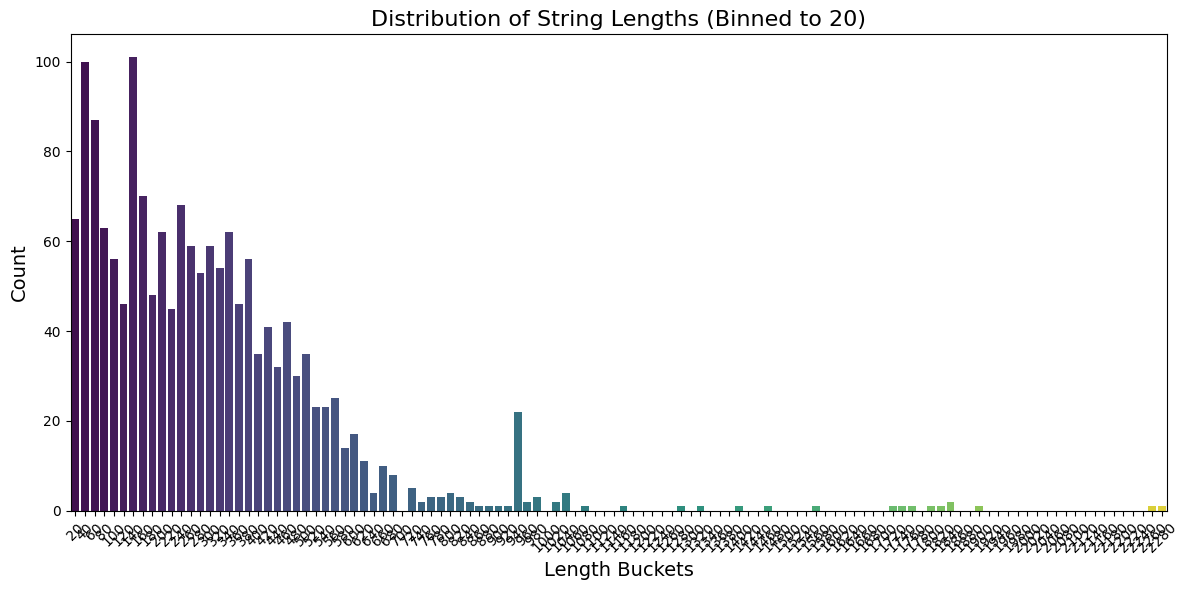

In [29]:
print(f"Lectures chunks stats:")
lecture_chunks_stats = generate_statistics(lectures_chunks_df)
display_statistics(lecture_chunks_stats, bucket_size=20)

It took around 2.39 seconds to generate chunks from lecture PDFs. These chunks have a very left skewed distribution of lengths with the majority of chunks having sub-100 string lengths and a decent spread between 200 to 680 string lengths. This makes sense because Anoop's lecture PDFs have very small sentences (talk about being to the point!)

References chunks stats:
Total number of non-empty strings: 5615
Average length of the strings: 705.2639358860196
Shortest string:
.

Longest string:
and therefore, exploring how to more efﬁ-
ciently utilize them is an important research
question. We are investigating more sophis-
ticated fusion techniques that can achieve
higher quality and efﬁciency.
• Better metrics : The limitations of lexical
matching metrics can mislead translation qual-
ity assessment. Therefore, developing met-
rics that can measure the contextual correct-
ness of LLM-generated translations is essen-
tial. Future research can also explore new
ways to evaluate the quality of machine trans-
lations more accurately, especially when using
LLMs.
Overall, our study provides valuable insights into
the strengths and weaknesses of GPT models for
machine translation and opens up opportunities for
future improvements and developments in this ﬁeld.
We investigated how GPT models can transform
machine translation as it is d

/var/folders/3s/jxqtlgkn21q5w9l6jfks93g00000gn/T/ipykernel_15222/1031886341.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_df = length_df.groupby('Bucket', as_index=False)['Count'].sum()
/var/folders/3s/jxqtlgkn21q5w9l6jfks93g00000gn/T/ipykernel_15222/1031886341.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=binned_df, x="Bucket", y="Count", palette="viridis")


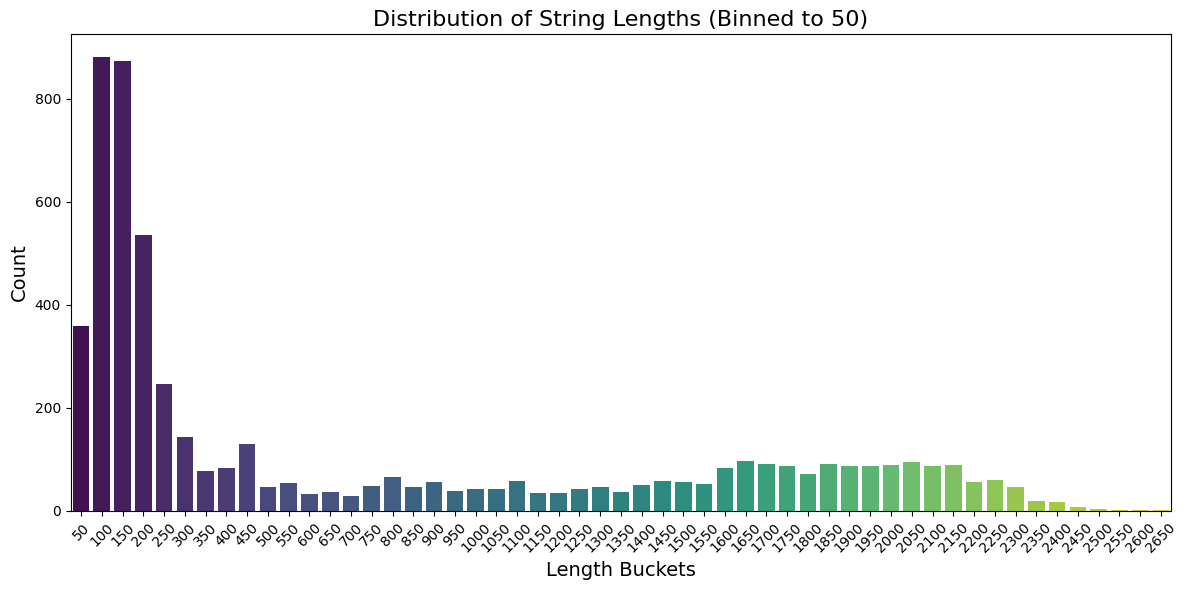

In [30]:
print(f"References chunks stats:")
reference_chunks_stats = generate_statistics(references_chunks_df)
display_statistics(reference_chunks_stats, bucket_size=50)

It took around 60.12 seconds to generate chunks from the references. These chunks have a huge spread of length with quite a few being in the range of 1600 to 2200 characters and a large majority being sub-200 characters in length. Such is the nature of reference materials. They are often very wordy!

Notebooks chunks stats:
Total number of non-empty strings: 1424
Average length of the strings: 542.8721910112359
Shortest string:
Text block:
## End


Longest string:
_ substantial increase in our industry's shipments of military electronics , which totalled about $5.4 billion compared to $4.9 billion in 1959 .
------------------------------------------------------------------------
_______ veteran diplomat with an extraordinary knowledge of Russian language , history and literature , Kennan recalls how , at the time of Hitler's attack on the Soviet Union in 1941 , he penned a private note to a State Department official , expressing the hope that `` never would we associate ourselves with Russian purposes in the areas of eastern Europe beyond her own boundaries '' .

Blanched peanuts , as prepared for making peanut _______ or for eating as nuts , are roasted seeds whose seedcoats have been rubbed off .

I just do what I'm _______ , and '' --
--------------------------------------------

/var/folders/3s/jxqtlgkn21q5w9l6jfks93g00000gn/T/ipykernel_15222/1031886341.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_df = length_df.groupby('Bucket', as_index=False)['Count'].sum()
/var/folders/3s/jxqtlgkn21q5w9l6jfks93g00000gn/T/ipykernel_15222/1031886341.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=binned_df, x="Bucket", y="Count", palette="viridis")


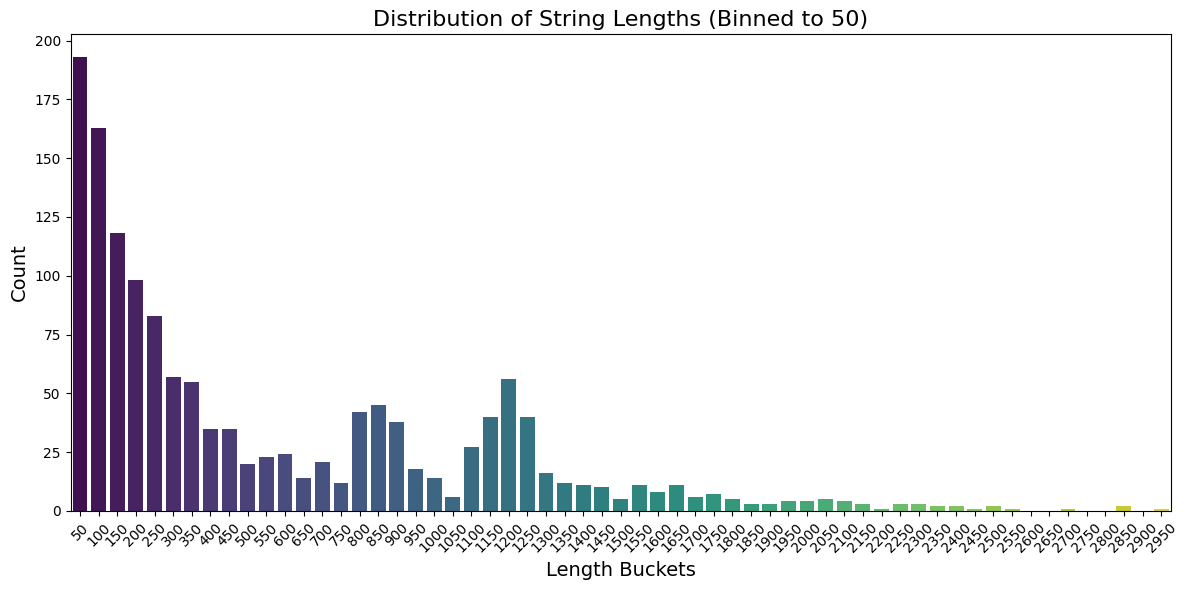

In [31]:
print(f"Notebooks chunks stats:")
notebook_chunks_stats = generate_statistics(notebooks_chunks_df)
display_statistics(notebook_chunks_stats, bucket_size=50)

The chunks for notebooks took 0.23 seconds to generate and mostly contain less than 200 character-long strings. Most code blocks and markdown blocks are not that text-heavy and that explains this observation. We also find a fair amount of chunks with 1100-1300 character lengths and these are usually the output blocks which often contain outputs from loop iterations or training statistics or text generation output which are likely to be very long in nature.

We do similar statistics for exercises and qas

Exercise chunks stats:
Total number of non-empty strings: 102
Average length of the strings: 303.11764705882354
Shortest string:
?

Longest string:
As can be seen pretty quickly from the a + 2b example, each new cell in the network is determined by taking 
the sum across all inputs of each input times the weight on that input’s arrow. From the example translations 
of the translator program, we can learn all the weights. Let’s call the four elements of the input a,b,c,d. From 
the examples, we can learn that the four outputs are (from left to right) (b + c), (a + b + c), (c + d), (a + c). 
(These expressions can be figured out by treating the examples as a system of equations and solving it rigor-
ously, or you can also figure it out just by eyeballing the examples). 
 
More formally, if we treat the Rigelese as a column vector of dimension 4 called R and the English as a col-
umn vector of dimension 4 called E, then we can write WR = E Where W is a matrix of the weights that can be 
w

/var/folders/3s/jxqtlgkn21q5w9l6jfks93g00000gn/T/ipykernel_15222/1031886341.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_df = length_df.groupby('Bucket', as_index=False)['Count'].sum()
/var/folders/3s/jxqtlgkn21q5w9l6jfks93g00000gn/T/ipykernel_15222/1031886341.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=binned_df, x="Bucket", y="Count", palette="viridis")


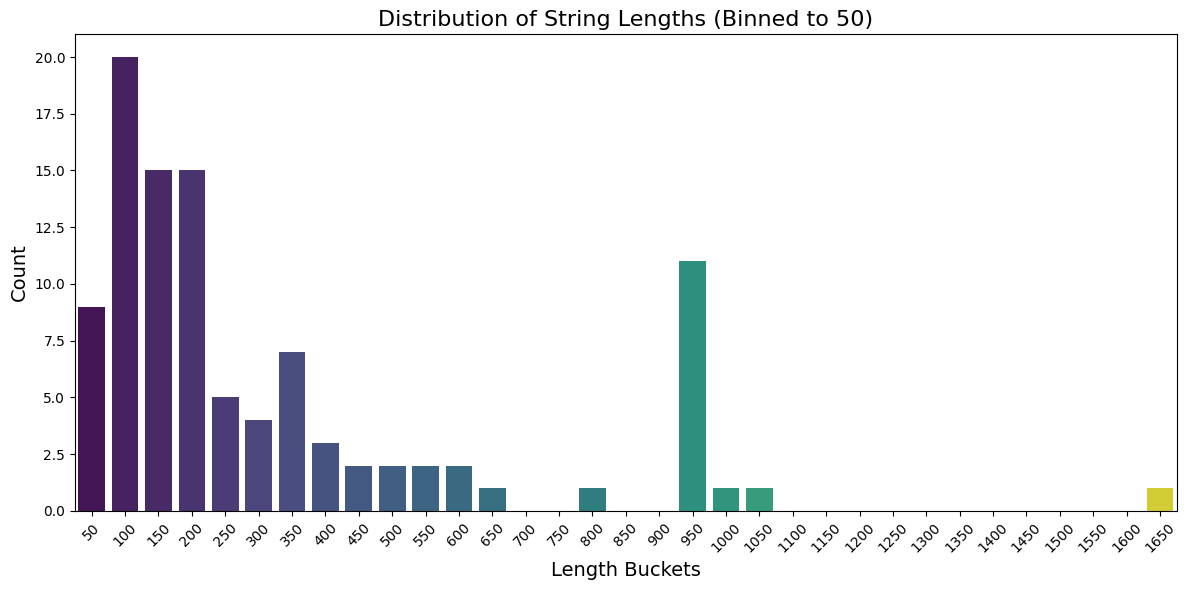

In [32]:
print(f"Exercise chunks stats:")
exercise_chunks_stats = generate_statistics(exercises_chunks_df)
display_statistics(exercise_chunks_stats, bucket_size=50)

QA chunks stats:
Total number of non-empty strings: 26
Average length of the strings: 841.1153846153846
Shortest string:
Info: No extra information given
Question: 11. In a four-gram MLP language model with an embedding dimension of d and a hidden layer size of h, what is the input dimension of the first linear layer?
    1. d
    2. 3d
    3. 4d
    4. h
Answer: - Correct answer: b. 3d


Longest string:
Info: (1) You are given the following training data for the prepositional phrase (PP) attachment task. v        n1        p        n2        Attachment
join        board        as        director        V
is        chairman        of        N.V.        N
using        crocidolite        in        filters        V
Where the attachment value of V indicates that p attaches to v and the attachment value of N indicates
that p attaches to n1.
In order to resolve PP attachment ambiguity we can train a probability model: P(A= N |v,n1,p,n2)
which predicts the attachment A as N if P >0.5 and V ot

/var/folders/3s/jxqtlgkn21q5w9l6jfks93g00000gn/T/ipykernel_15222/1031886341.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned_df = length_df.groupby('Bucket', as_index=False)['Count'].sum()
/var/folders/3s/jxqtlgkn21q5w9l6jfks93g00000gn/T/ipykernel_15222/1031886341.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=binned_df, x="Bucket", y="Count", palette="viridis")


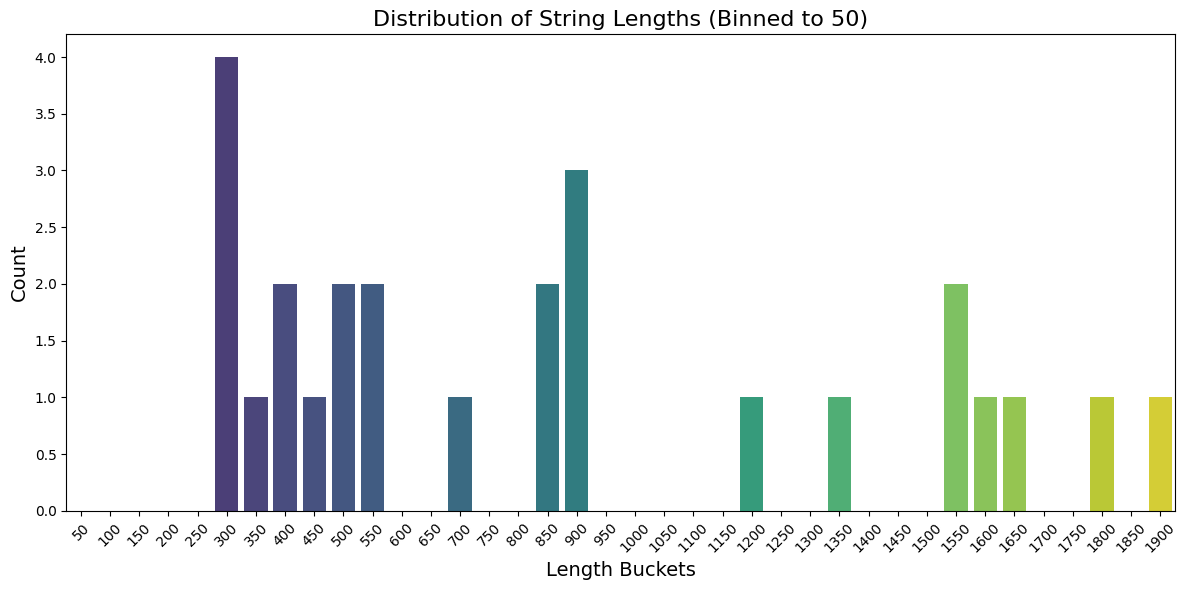

In [33]:
print(f"QA chunks stats:")
qa_chunks_stats = generate_statistics(qas_chunks_df)
display_statistics(qa_chunks_stats, bucket_size=50)

#### Generate embeddings JSONs

In [34]:
lectures_embedded = generate_embeddings_df_json_and_save(lectures_chunks_df, "lectures-embeddings.json")

Time taken to generate embeddings: 425.186031 seconds


In [35]:
references_embedded = generate_embeddings_df_json_and_save(lectures_chunks_df, "references-embeddings.json")

Time taken to generate embeddings: 385.161218 seconds


In [36]:
notebooks_embedded = generate_embeddings_df_json_and_save(notebooks_chunks_df, "notebooks-embeddings.json")

Time taken to generate embeddings: 342.280106 seconds


In [37]:
exercises_embedded = generate_embeddings_df_json_and_save(exercises_chunks_df, "exercises-embeddings.json")

Time taken to generate embeddings: 21.841311 seconds


In [38]:
qas_embedded = generate_embeddings_df_json_and_save(qas_chunks_df, "qas-embeddings.json")

Time taken to generate embeddings: 5.404748 seconds


#### Send to pinecone

In [39]:
lectures_pc_data = prepare_data_for_pinecone(lectures_embedded)

In [40]:
references_pc_data = prepare_data_for_pinecone(references_embedded)

In [41]:
notebooks_pc_data = prepare_data_for_pinecone(notebooks_embedded)

In [42]:
exercises_pc_data = prepare_data_for_pinecone(exercises_embedded)

In [43]:
qas_pc_data = prepare_data_for_pinecone(qas_embedded)

In [44]:
batch_upsert_data_into_index(lectures_pc_data, index, batch_size=10)

Time taken to upsert data: 39.605956


In [45]:
batch_upsert_data_into_index(references_pc_data, index, batch_size=10)

Time taken to upsert data: 37.606367


In [46]:
batch_upsert_data_into_index(notebooks_pc_data, index, batch_size=10)

Time taken to upsert data: 32.691896


In [47]:
batch_upsert_data_into_index(exercises_pc_data, index, batch_size=10)

Time taken to upsert data: 2.444182


In [48]:
batch_upsert_data_into_index(qas_pc_data, index, batch_size=10)

Time taken to upsert data: 0.679354
